In [111]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib as plt
from wrangle import wrangle
from acquire import acquire
from prepare import prepare, clean, remove_outliers
from functions import get_data_dictionary

In [112]:
pd.set_option("display.max_rows", None, "display.max_columns", None) 

pd.reset_option("display.max_rows", "display.max_columns")

In [116]:
df = acquire()
df = clean(df)
df = remove_outliers(df)

In [117]:
len(df)

838

In [114]:
df.excellent_rating.value_counts()

0    706
1    132
Name: excellent_rating, dtype: int64

In [115]:
df = acquire()

65 – 80 = Commodity Coffee The type used to make supermarket coffee, blends and instant.

80+ = Specialty Coffee The flavours are more subtle, the cup more balanced. At Pact we only buy coffees of 84+, though most of them score 86+.

90+ = Presidential Award These prestigious coffees make up less than 1% of the specialty coffee market, they’re just that rare. And that good.

# Clean Notes

#### Dropped Columns

These columns got dropped because they didn't offer any value
- 'Unnamed: 0'
- 'Owner'
- 'Farm.Name'
- 'Company'
- 'Expiration'
- 'Lot.Number'
- 'Mill'
- 'Producer'
- 'Certification.Address'
- 'Certification.Contact'
- 'ICO.Number'
- 'Certification.Body'
- 'In.Country.Partner'
- 'Owner.1'
- 'Species'
- 'Altitude'
- 'unit_of_measurement'
- 'altitude_low_meters' 
- 'altitude_high_meters'

#### Handle Nulls

Dropped any row that was missing a value from the following columns:
- 'Altitude'
- 'Region'
- 'Quakers'
- 'Harvest.Year'
- 'Variety'

Used the median value to fill in missing values from the following columns:
- 'Color'
- 'Processing.Method'

#### Convert Data Types

Changed the following columns data types:
- 'Bag.Weight' -> float
- 'Grading.Date' -> datetime
- 'Harvest.Year' -> int

#### Miscellaneous

- In 'Color' I Converted any Bluish-Green value to Blue-Green
- In 'Bag.Weight' converted lbs into kg
- Seperated 'Grading.Date' into three new columns 'grading_month', 'grading_year', 'grading_day'

#### Rename

Changed the following columns names to something more conventional:
- 'Country.of.Origin' -> 'country'
- 'Region' -> 'region'
- 'Number.of.Bags' -> 'number_of_bags'
- 'Harvest.Year' -> 'harvest_year', 
- 'Grading.Date' -> 'grading_date'
- 'Variety' -> 'variety'
- 'Processing.Method' -> 'processing_method'
- 'Aroma' -> 'aroma',
- 'Flavor' -> 'flavor'
- 'Aftertaste' -> 'aftertaste'
- 'Acidity' -> 'acidity'
- 'Body' -> 'body'
- 'Balance' -> 'balance'
- 'Uniformity' -> 'uniformity'
- 'Clean.Cup' -> 'clean_cup'
- 'Sweetness' -> 'sweetness'
- 'Cupper.Points' -> 'cupper_points',
- 'Total.Cup.Points' -> 'total_cup_points'
- 'Moisture' -> 'moisture'
- 'Category.One.Defects' -> 'category_one_defects', 
- 'Quakers' -> 'quakers'
- 'Color' -> 'color'
- 'Category.Two.Defects' -> 'category_two_defects'

#### Engineered columns

- 'grading_month' = from Grading.Date
- 'grading_year' = from Grading.Date
- 'grading_day' = from Grading.Date
- 'excellent_rating' = from total_cup_points >= 84
- 'total_bag_weight' = number_of_bags * bag_weight

#### Encode
- Created dummy columns for - 'variety', 'processing_method', 'color'


In [4]:
def clean(df):
    '''
    Takes in a pandas dataframe
    Designed to clean the 'arabica_data_cleaned.csv' file
    Dropped columns that didn't offer any value.
    Dropped any row that was missing a value from - Altitude, Region, Quakers, Harvest.Year, Variety
    Used the median value to fill in missing values from - Color, Processing.Method
    Convert Data Types
    Miscellaneous fixes
    Renamed columns
    returns a pandas dataframe
    '''
    
    # Dropped Columns
    col_remove = ['Unnamed: 0', 'Owner', 'Farm.Name', 'Company', 'Expiration','Lot.Number', 'Mill', 'Producer', 'Certification.Address', 'Certification.Contact', 'ICO.Number','Certification.Body','In.Country.Partner', 'Owner.1', ]
    df = df.drop(columns=col_remove)
    
    # Dropped any row that was missing a value from - Altitude, Region, Quakers, Harvest.Year, Variety
    df = df[~df['Altitude'].isnull()]
    df = df[~df['Region'].isnull()]
    df = df[~df['Quakers'].isnull()]
    df = df[~df['Harvest.Year'].isnull()]
    df = df[~df['Variety'].isnull()]
    
    # Used the median value to fill in missing values for - Color, Processing.Method
    df['Color'] = np.where(df['Color'] == 'None', 'Green', df.Color)
    df['Color'] = np.where(df['Color'].isnull(), 'Green', df.Color)
    df['Color'] = np.where(df['Color'] == 'Bluish-Green', 'Blue-Green', df.Color)
    df['Processing.Method'] = np.where(df['Processing.Method'].isnull(), 'Washed / Wet', df['Processing.Method'])

    # Convert Data Type of Bag.Weight and change from lbs to Kilograms
    df[['bag_weight', 'bag_weight_unit']]= df['Bag.Weight'].str.split(expand=True)
    df.bag_weight = df.bag_weight.astype(float)
    df.bag_weight = np.where(df.bag_weight_unit == 'lbs', round(df.bag_weight * 2.20462), df.bag_weight)
    df = df.drop(columns=['bag_weight_unit', 'Bag.Weight'])
    
    # Convert Data Type for Grading.Date and split by day,month, year 
    df['Grading.Date'] = pd.to_datetime(df['Grading.Date'])
    df['grading_month'] = df['Grading.Date'].dt.month
    df['grading_year'] = df['Grading.Date'].dt.year
    df['grading_day'] = df['Grading.Date'].dt.day

    # Miscellaneous fixes
    
    # Dropped this value of Harvest.Year because it equalled 'Mayo a Julio'
    df = df.drop(list(df[df['Harvest.Year']=='Mayo a Julio'].index))
    
    # Anywhere where given two years as a range for Harvest.Year I filled with grading year instead
    df['Harvest.Year'] = np.where(df['Harvest.Year'].str.contains('/'), df.grading_year, df['Harvest.Year'])
    df['Harvest.Year'] = np.where(df['Harvest.Year'].str.contains('-'), df.grading_year, df['Harvest.Year'])
    df['Harvest.Year'] = df['Harvest.Year'].astype(int)
    
    # Data Input Errors, used google to compare regions altitude to confirm correct altitude
    df.at[543,'altitude_mean_meters']=1100
    df.at[896, 'altitude_mean_meters']=1901.64
    df.at[1040, 'altitude_mean_meters']=1100
    df.at[1144, 'altitude_mean_meters']=1901.64
    df.at[41, 'altitude_mean_meters']=1150
    df.at[42, 'altitude_mean_meters']=1150
    
    # Removing older verisons or now un-needed columns
    more_col_remove = ['Species', 'Altitude', 'unit_of_measurement', 'altitude_low_meters', 'altitude_high_meters']
    df = df.drop(columns=more_col_remove)
    
    # Renamed Columns
    df = df.rename(columns={'Country.of.Origin':'country', 'Region':'region', 'Number.of.Bags':'number_of_bags', 'Harvest.Year':'harvest_year', 
                   'Grading.Date':'grading_date', 'Variety':'variety', 'Processing.Method':'processing_method', 'Aroma':'aroma',
                   'Flavor':'flavor', 'Aftertaste':'aftertaste', 'Acidity':'acidity', 'Body':'body', 'Balance':'balance',
                   'Uniformity':'uniformity', 'Clean.Cup':'clean_cup', 'Sweetness':'sweetness', 'Cupper.Points':'cupper_points',
                   'Total.Cup.Points':'total_cup_points', 'Moisture':'moisture', 'Category.One.Defects':'category_one_defects', 
                   'Quakers':'quakers', 'Color':'color', 'Category.Two.Defects': 'category_two_defects'})
    
    # Created Target Feature, Looking for total_cup_points greater than 85
    df['excellent_rating'] = np.where(df.total_cup_points > 85, 1, 0)
    
    return df
    

In [5]:
def encode(df):
    '''
    Encode takes in a pandas dataframe
    Creates dummy columns for variety, processing_method, & color
    Adds the new columns to pandas dataframe
    Drops non numeric columns
    Returns a pandas dataframe
    '''
    
    # Making Dummy Columns for variety, processing_method, & color
    dummy_columns = ['variety', 'processing_method', 'color']
    df_dummy = pd.get_dummies(df[dummy_columns])
    
    # Droppign Blue-Green from color since there are only two colors, its either green or its not
    df_dummy = df_dummy.drop(columns=['color_Blue-Green'])
    
    # Combine our dummy columns with our data frame
    df = pd.concat([df, df_dummy], axis = 1)
    
    # Drop any non numeric columns
    df = df.drop(columns=cols)
    
    return df

# Cleaning Work Below

In [6]:
# acquired not cleaned
df = acquire()

In [7]:
# got the data dictionary working
get_data_dictionary(df).head()

,Datatype,Description
Feature,,
Unnamed: 0,1311 non-null: int64,index column
Species,1311 non-null: object,Species of coffee bean (arabica or robusta)
Owner,1304 non-null: object,Owner of the farm
Country.of.Origin,1310 non-null: object,Where the bean came from
Farm.Name,955 non-null: object,Name of the farm


In [8]:
df.head(3)

,Unnamed: 0,Species,Owner,Country.of.Origin,Farm.Name,Lot.Number,Mill,ICO.Number,Company,Altitude,Region,Producer,Number.of.Bags,Bag.Weight,In.Country.Partner,Harvest.Year,Grading.Date,Owner.1,Variety,Processing.Method,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Clean.Cup,Sweetness,Cupper.Points,Total.Cup.Points,Moisture,Category.One.Defects,Quakers,Color,Category.Two.Defects,Expiration,Certification.Body,Certification.Address,Certification.Contact,unit_of_measurement,altitude_low_meters,altitude_high_meters,altitude_mean_meters
0,1,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,guji-hambela,METAD PLC,300,60 kg,METAD Agricultural Development plc,2014,"April 4th, 2015",metad plc,NaN,Washed / Wet,8.67,8.83,8.67,8.75,8.50,8.42,10.0,10.0,10.0,8.75,90.58,0.12,0,0.0,Green,0,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0
1,2,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,guji-hambela,METAD PLC,300,60 kg,METAD Agricultural Development plc,2014,"April 4th, 2015",metad plc,Other,Washed / Wet,8.75,8.67,8.50,8.58,8.42,8.42,10.0,10.0,10.0,8.58,89.92,0.12,0,0.0,Green,1,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0
2,3,Arabica,grounds for health admin,Guatemala,"san marcos barrancas ""san cristobal cuch",NaN,NaN,NaN,NaN,1600 - 1800 m,NaN,NaN,5,1,Specialty Coffee Association,NaN,"May 31st, 2010",Grounds for Health Admin,Bourbon,NaN,8.42,8.50,8.42,8.42,8.33,8.42,10.0,10.0,10.0,9.25,89.75,0.00,0,0.0,NaN,0,"May 31st, 2011",Specialty Coffee Association,36d0d00a3724338ba7937c52a378d085f2172daa,0878a7d4b9d35ddbf0fe2ce69a2062cceb45a660,m,1600.0,1800.0,1700.0


In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,1311.0,656.000763,378.598733,1.0,328.50,656.00,983.50,1312.00
Number.of.Bags,1311.0,153.887872,129.733734,0.0,14.50,175.00,275.00,1062.00
Aroma,1311.0,7.563806,0.378666,0.0,7.42,7.58,7.75,8.75
Flavor,1311.0,7.518070,0.399979,0.0,7.33,7.58,7.75,8.83
Aftertaste,1311.0,7.397696,0.405119,0.0,7.25,7.42,7.58,8.67
Acidity,1311.0,7.533112,0.381599,0.0,7.33,7.50,7.75,8.75
Body,1311.0,7.517727,0.359213,0.0,7.33,7.50,7.67,8.58
Balance,1311.0,7.517506,0.406316,0.0,7.33,7.50,7.75,8.75
Uniformity,1311.0,9.833394,0.559343,0.0,10.00,10.00,10.00,10.00
Clean.Cup,1311.0,9.833120,0.771350,0.0,10.00,10.00,10.00,10.00


# Clean

In [10]:
df.head(1)

,Unnamed: 0,Species,Owner,Country.of.Origin,Farm.Name,Lot.Number,Mill,ICO.Number,Company,Altitude,Region,Producer,Number.of.Bags,Bag.Weight,In.Country.Partner,Harvest.Year,Grading.Date,Owner.1,Variety,Processing.Method,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Clean.Cup,Sweetness,Cupper.Points,Total.Cup.Points,Moisture,Category.One.Defects,Quakers,Color,Category.Two.Defects,Expiration,Certification.Body,Certification.Address,Certification.Contact,unit_of_measurement,altitude_low_meters,altitude_high_meters,altitude_mean_meters
0,1,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,guji-hambela,METAD PLC,300,60 kg,METAD Agricultural Development plc,2014,"April 4th, 2015",metad plc,NaN,Washed / Wet,8.67,8.83,8.67,8.75,8.5,8.42,10.0,10.0,10.0,8.75,90.58,0.12,0,0.0,Green,0,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0


In [11]:
col_remove = ['Unnamed: 0', 'Owner', 'Farm.Name', 'Company', 'Lot.Number', 'Mill', 'Producer', 'Certification.Address', 'Certification.Contact', 'ICO.Number','Certification.Body','In.Country.Partner','unit_of_measurement', 'Owner.1', ]

In [12]:
df.head(1)

,Unnamed: 0,Species,Owner,Country.of.Origin,Farm.Name,Lot.Number,Mill,ICO.Number,Company,Altitude,Region,Producer,Number.of.Bags,Bag.Weight,In.Country.Partner,Harvest.Year,Grading.Date,Owner.1,Variety,Processing.Method,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Clean.Cup,Sweetness,Cupper.Points,Total.Cup.Points,Moisture,Category.One.Defects,Quakers,Color,Category.Two.Defects,Expiration,Certification.Body,Certification.Address,Certification.Contact,unit_of_measurement,altitude_low_meters,altitude_high_meters,altitude_mean_meters
0,1,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,guji-hambela,METAD PLC,300,60 kg,METAD Agricultural Development plc,2014,"April 4th, 2015",metad plc,NaN,Washed / Wet,8.67,8.83,8.67,8.75,8.5,8.42,10.0,10.0,10.0,8.75,90.58,0.12,0,0.0,Green,0,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0


In [13]:
df[(~df['Region'].isnull()) & (df['Altitude'].isnull())]

,Unnamed: 0,Species,Owner,Country.of.Origin,Farm.Name,Lot.Number,Mill,ICO.Number,Company,Altitude,Region,Producer,Number.of.Bags,Bag.Weight,In.Country.Partner,Harvest.Year,Grading.Date,Owner.1,Variety,Processing.Method,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Clean.Cup,Sweetness,Cupper.Points,Total.Cup.Points,Moisture,Category.One.Defects,Quakers,Color,Category.Two.Defects,Expiration,Certification.Body,Certification.Address,Certification.Contact,unit_of_measurement,altitude_low_meters,altitude_high_meters,altitude_mean_meters
17,18,Arabica,ethiopia commodity exchange,Ethiopia,NaN,NaN,NaN,010/0056,NaN,NaN,yirgacheffe,Green Gold Ethiopia | Phone: 0114342032,150,6,Ethiopia Commodity Exchange,2009/2010,"June 16th, 2010",Ethiopia Commodity Exchange,NaN,NaN,8.17,8.33,8.25,8.33,8.42,8.33,9.33,10.00,9.33,8.83,87.33,0.05,0,0.0,NaN,2,"June 16th, 2011",Ethiopia Commodity Exchange,a176532400aebdc345cf3d870f84ed3ecab6249e,61bbaf6a9f341e5782b8e7bd3ebf76aac89fe24b,m,NaN,NaN,NaN
24,25,Arabica,ji-ae ahn,Ethiopia,NaN,NaN,NaN,NaN,NaN,NaN,sidamo,NaN,100,60 kg,Specialty Coffee Institute of Asia,2013,"September 3rd, 2013",Ji-Ae Ahn,NaN,Natural / Dry,8.42,8.17,7.92,8.17,8.33,8.00,10.00,10.00,10.00,8.08,87.08,0.11,0,0.0,Bluish-Green,1,"September 3rd, 2014",Specialty Coffee Institute of Asia,726e4891cf2c9a4848768bd34b668124d12c4224,b70da261fcc84831e3e9620c30a8701540abc200,m,NaN,NaN,NaN
26,27,Arabica,ethiopia commodity exchange,Ethiopia,NaN,NaN,NaN,010/0056/Sidamo,NaN,NaN,sidamo,Green Gold Ethiopia | Phone: 0114342032,150,6,Ethiopia Commodity Exchange,2009/2010,"June 16th, 2010",Ethiopia Commodity Exchange,NaN,NaN,7.83,8.25,8.08,8.17,8.17,8.17,10.00,10.00,10.00,8.25,86.92,0.05,0,0.0,NaN,2,"June 16th, 2011",Ethiopia Commodity Exchange,a176532400aebdc345cf3d870f84ed3ecab6249e,61bbaf6a9f341e5782b8e7bd3ebf76aac89fe24b,m,NaN,NaN,NaN
36,37,Arabica,kona pacific farmers cooperative,United States (Hawaii),NaN,NaN,NaN,220452,kona pacific farmers cooperative,NaN,kona,NaN,10,100 lbs,Specialty Coffee Association,2012,"April 6th, 2012",Kona Pacific Farmers Cooperative,Hawaiian Kona,Natural / Dry,8.08,8.17,8.00,7.92,7.92,7.83,10.00,10.00,10.00,8.33,86.25,0.00,1,0.0,NaN,4,"April 6th, 2013",Specialty Coffee Association,36d0d00a3724338ba7937c52a378d085f2172daa,0878a7d4b9d35ddbf0fe2ce69a2062cceb45a660,ft,NaN,NaN,NaN
37,38,Arabica,kona pacific farmers cooperative,United States (Hawaii),kona pacific farmers cooperative,NaN,NaN,HDOA 210128 Kona Fancy,NaN,NaN,kona,Kona Pacific Farmers Co-Op,25,100 lbs,Specialty Coffee Association,2010,"January 28th, 2011",Kona Pacific Farmers Cooperative,NaN,NaN,8.25,8.42,8.08,7.75,7.67,7.83,10.00,10.00,10.00,8.25,86.25,0.00,2,0.0,NaN,1,"January 28th, 2012",Specialty Coffee Association,36d0d00a3724338ba7937c52a378d085f2172daa,0878a7d4b9d35ddbf0fe2ce69a2062cceb45a660,ft,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1286,1287,Arabica,eileen koyanagi,United States (Hawaii),NaN,NaN,NaN,KPBP 022414,kona pacific farmers cooperative,NaN,kona,NaN,3,100 lbs,Specialty Coffee Association,2014,"March 13th, 2014",Eileen Koyanagi,Hawaiian Kona,Natural / Dry,7.50,7.25,7.00,7.25,7.42,7.33,8.00,8.67,6.67,7.33,74.42,0.00,1,0.0,Blue-Green,2,"March 13th, 2015",Specialty Coffee Association,36d0d00a3724338ba7937c52a378d085f2172daa,0878a7d4b9d35ddbf0fe2ce69a2062cceb45a660,ft,NaN,NaN,NaN
1291,1292,Arabica,kona pacific farmers cooperative,United States (Hawaii),NaN,NaN,NaN,220456,kona pacific farmers cooperative,NaN,kona,NaN,22,100 lbs,Specialty Coffee Association,2012,"April 6th, 2012",Kona Pacific Farmers Cooperative,Hawaiian Kona,Natural / Dry,7.17,7.17,7.17,7.58,7.67,6.92,9.33,6.67,6.67,7.33,73.67,0.00,9,0.0,NaN,17,"April 6th, 2013",Specialty Coffee Association,36d0d00a3724338ba7937c52a378d085f2172daa,0878a7d4b9d35ddbf0fe2ce69a2062cceb45a660,ft,NaN,NaN,NaN
1292,1293,Arabica,bourbon specialty coffees,Braz

Anything not labeled in lbs or kg must be dropped

In [14]:
df[df['Country.of.Origin'] == 'United States (Hawaii)'].Altitude.value_counts()

1400ft     1
2000 ft    1
Name: Altitude, dtype: int64

In [15]:
df.head(3)

,Unnamed: 0,Species,Owner,Country.of.Origin,Farm.Name,Lot.Number,Mill,ICO.Number,Company,Altitude,Region,Producer,Number.of.Bags,Bag.Weight,In.Country.Partner,Harvest.Year,Grading.Date,Owner.1,Variety,Processing.Method,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Clean.Cup,Sweetness,Cupper.Points,Total.Cup.Points,Moisture,Category.One.Defects,Quakers,Color,Category.Two.Defects,Expiration,Certification.Body,Certification.Address,Certification.Contact,unit_of_measurement,altitude_low_meters,altitude_high_meters,altitude_mean_meters
0,1,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,guji-hambela,METAD PLC,300,60 kg,METAD Agricultural Development plc,2014,"April 4th, 2015",metad plc,NaN,Washed / Wet,8.67,8.83,8.67,8.75,8.50,8.42,10.0,10.0,10.0,8.75,90.58,0.12,0,0.0,Green,0,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0
1,2,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,guji-hambela,METAD PLC,300,60 kg,METAD Agricultural Development plc,2014,"April 4th, 2015",metad plc,Other,Washed / Wet,8.75,8.67,8.50,8.58,8.42,8.42,10.0,10.0,10.0,8.58,89.92,0.12,0,0.0,Green,1,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0
2,3,Arabica,grounds for health admin,Guatemala,"san marcos barrancas ""san cristobal cuch",NaN,NaN,NaN,NaN,1600 - 1800 m,NaN,NaN,5,1,Specialty Coffee Association,NaN,"May 31st, 2010",Grounds for Health Admin,Bourbon,NaN,8.42,8.50,8.42,8.42,8.33,8.42,10.0,10.0,10.0,9.25,89.75,0.00,0,0.0,NaN,0,"May 31st, 2011",Specialty Coffee Association,36d0d00a3724338ba7937c52a378d085f2172daa,0878a7d4b9d35ddbf0fe2ce69a2062cceb45a660,m,1600.0,1800.0,1700.0


## Trying to salvage empty Altitude rows by looking at farm name and region of other observations

In [16]:
df[(~df['Farm.Name'].isnull()) & (df['Altitude'].isnull())][['Farm.Name', 'Altitude']]

,Farm.Name,Altitude
37,kona pacific farmers cooperative,NaN
38,"phone number | 0911-51-08-01, email | at",NaN
46,kaasayi,NaN
52,la esperanza y anexos,NaN
59,seid damtew coffee planation,NaN
...,...,...
1262,conquista / morito,NaN
1265,conquista / morito,NaN
1275,conquista / morito,NaN
1283,conquista / morito,NaN


In [17]:
# kona missing altitude
kona_df = df[df['Region']=='kona']
kona_df[['Farm.Name', 'Altitude', 'Region']]['Farm.Name'].value_counts()

kona pacific farmers cooperative    6
arianna farms                       1
hula daddy kona coffee              1
kona farms                          1
Name: Farm.Name, dtype: int64

In [18]:
df = df[~df['Altitude'].isnull()]

In [19]:
kona_df[kona_df[['Farm.Name', 'Altitude']]['Farm.Name']== 'kona pacific farmers cooperative']

,Unnamed: 0,Species,Owner,Country.of.Origin,Farm.Name,Lot.Number,Mill,ICO.Number,Company,Altitude,Region,Producer,Number.of.Bags,Bag.Weight,In.Country.Partner,Harvest.Year,Grading.Date,Owner.1,Variety,Processing.Method,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Clean.Cup,Sweetness,Cupper.Points,Total.Cup.Points,Moisture,Category.One.Defects,Quakers,Color,Category.Two.Defects,Expiration,Certification.Body,Certification.Address,Certification.Contact,unit_of_measurement,altitude_low_meters,altitude_high_meters,altitude_mean_meters
37,38,Arabica,kona pacific farmers cooperative,United States (Hawaii),kona pacific farmers cooperative,NaN,NaN,HDOA 210128 Kona Fancy,NaN,NaN,kona,Kona Pacific Farmers Co-Op,25,100 lbs,Specialty Coffee Association,2010,"January 28th, 2011",Kona Pacific Farmers Cooperative,NaN,NaN,8.25,8.42,8.08,7.75,7.67,7.83,10.00,10.00,10.0,8.25,86.25,0.00,2,0.0,NaN,1,"January 28th, 2012",Specialty Coffee Association,36d0d00a3724338ba7937c52a378d085f2172daa,0878a7d4b9d35ddbf0fe2ce69a2062cceb45a660,ft,NaN,NaN,NaN
95,96,Arabica,kona pacific farmers cooperative,United States (Hawaii),kona pacific farmers cooperative,NaN,kona pacific farmers cooperative,HDOA 210310,NaN,NaN,kona,NaN,27,0 lbs,Specialty Coffee Association,NaN,"May 17th, 2010",Kona Pacific Farmers Cooperative,NaN,NaN,7.50,7.92,8.25,7.83,7.92,7.75,10.00,10.00,10.0,7.92,85.08,0.00,0,0.0,NaN,0,"May 17th, 2011",Specialty Coffee Association,36d0d00a3724338ba7937c52a378d085f2172daa,0878a7d4b9d35ddbf0fe2ce69a2062cceb45a660,ft,NaN,NaN,NaN
104,105,Arabica,kona pacific farmers cooperative,United States (Hawaii),kona pacific farmers cooperative,NaN,NaN,HDOA#210306,NaN,NaN,kona,NaN,15,100 lbs,Specialty Coffee Association,NaN,"February 24th, 2011",Kona Pacific Farmers Cooperative,NaN,NaN,7.75,7.92,7.75,7.75,8.00,8.00,10.00,10.00,10.0,7.83,85.00,0.00,0,0.0,NaN,1,"February 24th, 2012",Specialty Coffee Association,36d0d00a3724338ba7937c52a378d085f2172daa,0878a7d4b9d35ddbf0fe2ce69a2062cceb45a660,ft,NaN,NaN,NaN
393,394,Arabica,kona pacific farmers cooperative,United States (Hawaii),kona pacific farmers cooperative,NaN,NaN,HDOA 210127 Kona Extra Fancy,NaN,NaN,kona,Kona Pacific Farmers Co-Op,12,60 kg,Specialty Coffee Association,2010,"December 27th, 2010",Kona Pacific Farmers Cooperative,NaN,NaN,7.50,7.92,7.42,7.67,7.83,7.58,10.00,10.00,10.0,7.50,83.42,0.01,0,0.0,NaN,0,"December 27th, 2011",Specialty Coffee Association,36d0d00a3724338ba7937c52a378d085f2172daa,0878a7d4b9d35ddbf0fe2ce69a2062cceb45a660,ft,NaN,NaN,NaN
858,859,Arabica,kona pacific farmers cooperative,United States (Hawaii),kona pacific farmers cooperative,NaN,kona pacific farmers cooperative,HDOA 210281,NaN,NaN,kona,NaN,30,0 lbs,Specialty Coffee Association,NaN,"May 24th, 2010",Kona Pacific Farmers Cooperative,NaN,NaN,7.25,7.58,7.83,7.67,7.75,7.75,9.33,9.33,10.0,7.33,81.83,0.02,3,0.0,NaN,12,"May 24th, 2011",Specialty Coffee Association,36d0d00a3724338ba7937c52a378d085f2172daa,0878a7d4b9d35ddbf0fe2ce69a2062cceb45a660,ft,NaN,NaN,NaN
949,950,Arabica,kona pacific farmers cooperative,United States (Hawaii),kona pacific farmers cooperative,NaN,kona pacific farmers cooperative,HDOA 210520,NaN,NaN,kona,NaN,27,0 lbs,Specialty Coffee Association,NaN,"May 24th, 2010",Kona Pacific Farmers Cooperative,Peaberry,NaN,7.83,7.00,7.00,7.58,7.58,7.50,10.00,10.00,10.0,6.92,81.42,0.01,0,0.0,NaN,10,"May 24th, 2011",Specialty Coffee Association,36d0d00a3724338ba7937c52a378d085f2172daa,0878a7d4b9d35ddbf0fe2ce69a2062cceb45a660,ft,NaN,NaN,NaN


### Salvage not possible, I will be Removing all altitude missing values

# looking at missing color values

In [20]:
# 142 missing values
# Need to rename Bluish-Green with just Blue-Green
# fill in NA with Green

In [21]:
len(df[df['Color'].isnull()])

142

In [22]:
df['Color'].value_counts(dropna=False)

Green           752
NaN             142
Bluish-Green     81
Blue-Green       69
None             44
Name: Color, dtype: int64

In [23]:
df['Color'] = np.where(df['Color'] == 'Bluish-Green', 'Blue-Green', df.Color)

In [24]:
df['Color'] = np.where(df['Color'] == 'None', 'Green', df.Color)
df['Color'] = np.where(df['Color'].isnull(), 'Green', df.Color)

In [25]:
df[df['Color'].isnull()]

,Unnamed: 0,Species,Owner,Country.of.Origin,Farm.Name,Lot.Number,Mill,ICO.Number,Company,Altitude,Region,Producer,Number.of.Bags,Bag.Weight,In.Country.Partner,Harvest.Year,Grading.Date,Owner.1,Variety,Processing.Method,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Clean.Cup,Sweetness,Cupper.Points,Total.Cup.Points,Moisture,Category.One.Defects,Quakers,Color,Category.Two.Defects,Expiration,Certification.Body,Certification.Address,Certification.Contact,unit_of_measurement,altitude_low_meters,altitude_high_meters,altitude_mean_meters


# Processing.Method

In [26]:
df['Processing.Method'].value_counts(dropna=False)

Washed / Wet                 739
Natural / Dry                180
NaN                           81
Semi-washed / Semi-pulped     53
Other                         25
Pulped natural / honey        10
Name: Processing.Method, dtype: int64

In [27]:
df['Processing.Method'] = np.where(df['Processing.Method'].isnull(), 'Washed / Wet', df['Processing.Method'])

# Variety

In [28]:
# acquired not cleaned
df = acquire()
df.Variety.value_counts(dropna=False)

df = df[~df['Variety'].isnull()]

In [29]:
df.head()

,Unnamed: 0,Species,Owner,Country.of.Origin,Farm.Name,Lot.Number,Mill,ICO.Number,Company,Altitude,Region,Producer,Number.of.Bags,Bag.Weight,In.Country.Partner,Harvest.Year,Grading.Date,Owner.1,Variety,Processing.Method,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Clean.Cup,Sweetness,Cupper.Points,Total.Cup.Points,Moisture,Category.One.Defects,Quakers,Color,Category.Two.Defects,Expiration,Certification.Body,Certification.Address,Certification.Contact,unit_of_measurement,altitude_low_meters,altitude_high_meters,altitude_mean_meters
1,2,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,guji-hambela,METAD PLC,300,60 kg,METAD Agricultural Development plc,2014,"April 4th, 2015",metad plc,Other,Washed / Wet,8.75,8.67,8.50,8.58,8.42,8.42,10.0,10.0,10.0,8.58,89.92,0.12,0,0.0,Green,1,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0
2,3,Arabica,grounds for health admin,Guatemala,"san marcos barrancas ""san cristobal cuch",NaN,NaN,NaN,NaN,1600 - 1800 m,NaN,NaN,5,1,Specialty Coffee Association,NaN,"May 31st, 2010",Grounds for Health Admin,Bourbon,NaN,8.42,8.50,8.42,8.42,8.33,8.42,10.0,10.0,10.0,9.25,89.75,0.00,0,0.0,NaN,0,"May 31st, 2011",Specialty Coffee Association,36d0d00a3724338ba7937c52a378d085f2172daa,0878a7d4b9d35ddbf0fe2ce69a2062cceb45a660,m,1600.0,1800.0,1700.0
4,5,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,guji-hambela,METAD PLC,300,60 kg,METAD Agricultural Development plc,2014,"April 4th, 2015",metad plc,Other,Washed / Wet,8.25,8.50,8.25,8.50,8.42,8.33,10.0,10.0,10.0,8.58,88.83,0.12,0,0.0,Green,2,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0
6,7,Arabica,hugo valdivia,Peru,NaN,NaN,hvc,NaN,richmond investment-coffee department,NaN,NaN,HVC,100,69 kg,Specialty Coffee Institute of Asia,2012,"September 17th, 2012",Hugo Valdivia,Other,Washed / Wet,8.42,8.50,8.33,8.50,8.25,8.25,10.0,10.0,10.0,8.50,88.75,0.11,0,0.0,Bluish-Green,0,"September 17th, 2013",Specialty Coffee Institute of Asia,726e4891cf2c9a4848768bd34b668124d12c4224,b70da261fcc84831e3e9620c30a8701540abc200,m,NaN,NaN,NaN
9,10,Arabica,diamond enterprise plc,Ethiopia,tulla coffee farm,NaN,tulla coffee farm,2014/15,diamond enterprise plc,1795-1850,"snnp/kaffa zone,gimbowereda",Diamond Enterprise Plc,50,60 kg,METAD Agricultural Development plc,2014,"March 30th, 2015",Diamond Enterprise Plc,Other,Natural / Dry,8.08,8.58,8.50,8.50,7.67,8.42,10.0,10.0,10.0,8.50,88.25,0.10,0,0.0,Green,4,"March 29th, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1795.0,1850.0,1822.5


In [30]:
df = acquire()
df.head(1)

,Unnamed: 0,Species,Owner,Country.of.Origin,Farm.Name,Lot.Number,Mill,ICO.Number,Company,Altitude,Region,Producer,Number.of.Bags,Bag.Weight,In.Country.Partner,Harvest.Year,Grading.Date,Owner.1,Variety,Processing.Method,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Clean.Cup,Sweetness,Cupper.Points,Total.Cup.Points,Moisture,Category.One.Defects,Quakers,Color,Category.Two.Defects,Expiration,Certification.Body,Certification.Address,Certification.Contact,unit_of_measurement,altitude_low_meters,altitude_high_meters,altitude_mean_meters
0,1,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,guji-hambela,METAD PLC,300,60 kg,METAD Agricultural Development plc,2014,"April 4th, 2015",metad plc,NaN,Washed / Wet,8.67,8.83,8.67,8.75,8.5,8.42,10.0,10.0,10.0,8.75,90.58,0.12,0,0.0,Green,0,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0


In [31]:
df.columns[df.isnull().sum() > 0]

Index(['Owner', 'Country.of.Origin', 'Farm.Name', 'Lot.Number', 'Mill',
       'ICO.Number', 'Company', 'Altitude', 'Region', 'Producer',
       'Harvest.Year', 'Owner.1', 'Variety', 'Processing.Method', 'Quakers',
       'Color', 'altitude_low_meters', 'altitude_high_meters',
       'altitude_mean_meters'],
      dtype='object')

In [32]:
df = df[~df['Region'].isnull()]
df = df[~df['Quakers'].isnull()]
df = df[~df['Harvest.Year'].isnull()]

In [33]:
df.isnull().sum()

Unnamed: 0                 0
Species                    0
Owner                      7
Country.of.Origin          0
Farm.Name                299
Lot.Number               970
Mill                     247
ICO.Number               116
Company                  164
Altitude                 152
Region                     0
Producer                 170
Number.of.Bags             0
Bag.Weight                 0
In.Country.Partner         0
Harvest.Year               0
Grading.Date               0
Owner.1                    7
Variety                  137
Processing.Method        102
Aroma                      0
Flavor                     0
Aftertaste                 0
Acidity                    0
Body                       0
Balance                    0
Uniformity                 0
Clean.Cup                  0
Sweetness                  0
Cupper.Points              0
Total.Cup.Points           0
Moisture                   0
Category.One.Defects       0
Quakers                    0
Color         

In [34]:
df.head()

,Unnamed: 0,Species,Owner,Country.of.Origin,Farm.Name,Lot.Number,Mill,ICO.Number,Company,Altitude,Region,Producer,Number.of.Bags,Bag.Weight,In.Country.Partner,Harvest.Year,Grading.Date,Owner.1,Variety,Processing.Method,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Clean.Cup,Sweetness,Cupper.Points,Total.Cup.Points,Moisture,Category.One.Defects,Quakers,Color,Category.Two.Defects,Expiration,Certification.Body,Certification.Address,Certification.Contact,unit_of_measurement,altitude_low_meters,altitude_high_meters,altitude_mean_meters
0,1,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,guji-hambela,METAD PLC,300,60 kg,METAD Agricultural Development plc,2014,"April 4th, 2015",metad plc,NaN,Washed / Wet,8.67,8.83,8.67,8.75,8.50,8.42,10.0,10.0,10.00,8.75,90.58,0.12,0,0.0,Green,0,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0
1,2,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,guji-hambela,METAD PLC,300,60 kg,METAD Agricultural Development plc,2014,"April 4th, 2015",metad plc,Other,Washed / Wet,8.75,8.67,8.50,8.58,8.42,8.42,10.0,10.0,10.00,8.58,89.92,0.12,0,0.0,Green,1,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0
3,4,Arabica,yidnekachew dabessa,Ethiopia,yidnekachew dabessa coffee plantation,NaN,wolensu,NaN,yidnekachew debessa coffee plantation,1800-2200,oromia,Yidnekachew Dabessa Coffee Plantation,320,60 kg,METAD Agricultural Development plc,2014,"March 26th, 2015",Yidnekachew Dabessa,NaN,Natural / Dry,8.17,8.58,8.42,8.42,8.50,8.25,10.0,10.0,10.00,8.67,89.00,0.11,0,0.0,Green,2,"March 25th, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1800.0,2200.0,2000.0
4,5,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,guji-hambela,METAD PLC,300,60 kg,METAD Agricultural Development plc,2014,"April 4th, 2015",metad plc,Other,Washed / Wet,8.25,8.50,8.25,8.50,8.42,8.33,10.0,10.0,10.00,8.58,88.83,0.12,0,0.0,Green,2,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0
7,8,Arabica,ethiopia commodity exchange,Ethiopia,aolme,NaN,c.p.w.e,010/0338,NaN,1570-1700,oromia,Bazen Agricultural & Industrial Dev't Plc,300,60 kg,Ethiopia Commodity Exchange,March 2010,"September 2nd, 2010",Ethiopia Commodity Exchange,NaN,NaN,8.25,8.33,8.50,8.42,8.33,8.50,10.0,10.0,9.33,9.00,88.67,0.03,0,0.0,NaN,0,"September 2nd, 2011",Ethiopia Commodity Exchange,a176532400aebdc345cf3d870f84ed3ecab6249e,61bbaf6a9f341e5782b8e7bd3ebf76aac89fe24b,m,1570.0,1700.0,1635.0


# Working with Bag Weight

In [35]:
df['Bag.Weight'].value_counts(dropna = False)

1 kg        322
60 kg       230
69 kg       194
70 kg       147
2 kg        107
100 lbs      45
30 kg        28
6            18
20 kg        14
50 kg        14
5 lbs        13
59 kg         9
10 kg         8
3 lbs         7
5 kg          5
2 lbs         5
18975 kg      4
80 kg         4
4 lbs         3
46 kg         3
1 lbs         3
40 kg         2
35 kg         2
12000 kg      2
25 kg         2
9000 kg       2
29 kg         2
6 kg          2
15 kg         2
19200 kg      2
66 kg         2
1             2
2 kg,lbs      1
0 kg          1
18000 kg      1
55 lbs        1
24 kg         1
2             1
4 kg          1
67 kg         1
3 kg          1
8 kg          1
100 kg        1
1218 kg       1
18 kg         1
1 kg,lbs      1
350 kg        1
1500 kg       1
80 lbs        1
34 kg         1
130 lbs       1
Name: Bag.Weight, dtype: int64

In [36]:
df[['bag_weight', 'bag_weight_unit']]= df['Bag.Weight'].str.split(expand=True)

In [37]:
df[['bag_weight', 'bag_weight_unit', 'Bag.Weight']]

,bag_weight,bag_weight_unit,Bag.Weight
0,60,kg,60 kg
1,60,kg,60 kg
3,60,kg,60 kg
4,60,kg,60 kg
7,60,kg,60 kg
...,...,...,...
1306,1,kg,1 kg
1307,2,kg,2 kg
1308,69,kg,69 kg
1309,1,kg,1 kg


In [38]:
df.bag_weight_unit.value_counts()

kg        1122
lbs         79
kg,lbs       2
Name: bag_weight_unit, dtype: int64

In [39]:
df.bag_weight = df.bag_weight.astype(float)

In [40]:
df.bag_weight.dtype

dtype('float64')

In [41]:
df.bag_weight = np.where(df.bag_weight_unit == 'lbs', round(df.bag_weight * 2.20462), df.bag_weight)

In [42]:
df[['bag_weight', 'bag_weight_unit', 'Bag.Weight']][df.bag_weight_unit == 'lbs']

,bag_weight,bag_weight_unit,Bag.Weight
21,7.0,lbs,3 lbs
33,4.0,lbs,2 lbs
36,220.0,lbs,100 lbs
37,220.0,lbs,100 lbs
60,11.0,lbs,5 lbs
...,...,...,...
1267,220.0,lbs,100 lbs
1286,220.0,lbs,100 lbs
1291,220.0,lbs,100 lbs
1296,220.0,lbs,100 lbs


In [43]:
df = acquire()
df.head(1)

,Unnamed: 0,Species,Owner,Country.of.Origin,Farm.Name,Lot.Number,Mill,ICO.Number,Company,Altitude,Region,Producer,Number.of.Bags,Bag.Weight,In.Country.Partner,Harvest.Year,Grading.Date,Owner.1,Variety,Processing.Method,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Clean.Cup,Sweetness,Cupper.Points,Total.Cup.Points,Moisture,Category.One.Defects,Quakers,Color,Category.Two.Defects,Expiration,Certification.Body,Certification.Address,Certification.Contact,unit_of_measurement,altitude_low_meters,altitude_high_meters,altitude_mean_meters
0,1,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,guji-hambela,METAD PLC,300,60 kg,METAD Agricultural Development plc,2014,"April 4th, 2015",metad plc,NaN,Washed / Wet,8.67,8.83,8.67,8.75,8.5,8.42,10.0,10.0,10.0,8.75,90.58,0.12,0,0.0,Green,0,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0


In [44]:
# Splitting up the Grading Date
df['Grading.Date'] = pd.to_datetime(df['Grading.Date'])

In [45]:
df['grading_month'] = df['Grading.Date'].dt.month

In [46]:
df['grading_year'] = df['Grading.Date'].dt.year

In [47]:
df['grading_day'] = df['Grading.Date'].dt.day

In [48]:
df = df.drop(list(df[df['Harvest.Year']=='Mayo a Julio'].index))
len(df)

1308

In [49]:
df['Harvest.Year'] = np.where(df['Harvest.Year'].str.contains('/'), df.grading_year, df['Harvest.Year'])
df['Harvest.Year'] = np.where(df['Harvest.Year'].str.contains('-'), df.grading_year, df['Harvest.Year'])

In [50]:
df = acquire()

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1311 entries, 0 to 1310
Data columns (total 44 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             1311 non-null   int64  
 1   Species                1311 non-null   object 
 2   Owner                  1304 non-null   object 
 3   Country.of.Origin      1310 non-null   object 
 4   Farm.Name              955 non-null    object 
 5   Lot.Number             270 non-null    object 
 6   Mill                   1001 non-null   object 
 7   ICO.Number             1165 non-null   object 
 8   Company                1102 non-null   object 
 9   Altitude               1088 non-null   object 
 10  Region                 1254 non-null   object 
 11  Producer               1081 non-null   object 
 12  Number.of.Bags         1311 non-null   int64  
 13  Bag.Weight             1311 non-null   object 
 14  In.Country.Partner     1311 non-null   object 
 15  Harv

In [52]:
df[((df['altitude_low_meters'] + df['altitude_high_meters']) / 2) != df['altitude_mean_meters']]

,Unnamed: 0,Species,Owner,Country.of.Origin,Farm.Name,Lot.Number,Mill,ICO.Number,Company,Altitude,Region,Producer,Number.of.Bags,Bag.Weight,In.Country.Partner,Harvest.Year,Grading.Date,Owner.1,Variety,Processing.Method,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Clean.Cup,Sweetness,Cupper.Points,Total.Cup.Points,Moisture,Category.One.Defects,Quakers,Color,Category.Two.Defects,Expiration,Certification.Body,Certification.Address,Certification.Contact,unit_of_measurement,altitude_low_meters,altitude_high_meters,altitude_mean_meters
5,6,Arabica,ji-ae ahn,Brazil,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100,30 kg,Specialty Coffee Institute of Asia,2013,"September 3rd, 2013",Ji-Ae Ahn,NaN,Natural / Dry,8.58,8.42,8.42,8.50,8.25,8.33,10.00,10.00,10.00,8.33,88.83,0.11,0,0.0,Bluish-Green,1,"September 3rd, 2014",Specialty Coffee Institute of Asia,726e4891cf2c9a4848768bd34b668124d12c4224,b70da261fcc84831e3e9620c30a8701540abc200,m,NaN,NaN,NaN
6,7,Arabica,hugo valdivia,Peru,NaN,NaN,hvc,NaN,richmond investment-coffee department,NaN,NaN,HVC,100,69 kg,Specialty Coffee Institute of Asia,2012,"September 17th, 2012",Hugo Valdivia,Other,Washed / Wet,8.42,8.50,8.33,8.50,8.25,8.25,10.00,10.00,10.00,8.50,88.75,0.11,0,0.0,Bluish-Green,0,"September 17th, 2013",Specialty Coffee Institute of Asia,726e4891cf2c9a4848768bd34b668124d12c4224,b70da261fcc84831e3e9620c30a8701540abc200,m,NaN,NaN,NaN
17,18,Arabica,ethiopia commodity exchange,Ethiopia,NaN,NaN,NaN,010/0056,NaN,NaN,yirgacheffe,Green Gold Ethiopia | Phone: 0114342032,150,6,Ethiopia Commodity Exchange,2009/2010,"June 16th, 2010",Ethiopia Commodity Exchange,NaN,NaN,8.17,8.33,8.25,8.33,8.42,8.33,9.33,10.00,9.33,8.83,87.33,0.05,0,0.0,NaN,2,"June 16th, 2011",Ethiopia Commodity Exchange,a176532400aebdc345cf3d870f84ed3ecab6249e,61bbaf6a9f341e5782b8e7bd3ebf76aac89fe24b,m,NaN,NaN,NaN
24,25,Arabica,ji-ae ahn,Ethiopia,NaN,NaN,NaN,NaN,NaN,NaN,sidamo,NaN,100,60 kg,Specialty Coffee Institute of Asia,2013,"September 3rd, 2013",Ji-Ae Ahn,NaN,Natural / Dry,8.42,8.17,7.92,8.17,8.33,8.00,10.00,10.00,10.00,8.08,87.08,0.11,0,0.0,Bluish-Green,1,"September 3rd, 2014",Specialty Coffee Institute of Asia,726e4891cf2c9a4848768bd34b668124d12c4224,b70da261fcc84831e3e9620c30a8701540abc200,m,NaN,NaN,NaN
26,27,Arabica,ethiopia commodity exchange,Ethiopia,NaN,NaN,NaN,010/0056/Sidamo,NaN,NaN,sidamo,Green Gold Ethiopia | Phone: 0114342032,150,6,Ethiopia Commodity Exchange,2009/2010,"June 16th, 2010",Ethiopia Commodity Exchange,NaN,NaN,7.83,8.25,8.08,8.17,8.17,8.17,10.00,10.00,10.00,8.25,86.92,0.05,0,0.0,NaN,2,"June 16th, 2011",Ethiopia Commodity Exchange,a176532400aebdc345cf3d870f84ed3ecab6249e,61bbaf6a9f341e5782b8e7bd3ebf76aac89fe24b,m,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1291,1292,Arabica,kona pacific farmers cooperative,United States (Hawaii),NaN,NaN,NaN,220456,kona pacific farmers cooperative,NaN,kona,NaN,22,100 lbs,Specialty Coffee Association,2012,"April 6th, 2012",Kona Pacific Farmers Cooperative,Hawaiian Kona,Natural / Dry,7.17,7.17,7.17,7.58,7.67,6.92,9.33,6.67,6.67,7.33,73.67,0.00,9,0.0,NaN,17,"April 6th, 2013",Specialty Coffee Association,36d0d00a3724338ba7937c52a378d085f2172daa,0878a7d4b9d35ddbf0fe2ce69a2062cceb45a660,ft,NaN,NaN,NaN
1292,1293,Arabica,bourbon specialty coffees,Brazil,NaN,43102245/P4615,dinamo armazens gerais ltda,002/4542/0189,bourbon specialty coffees,NaN,campos altos - cerrado,NaN,300,60 kg,Brazil Specialty Coffee Association,2016,"December 28th, 2015",BOURBON SPECIALTY COFFEES,NaN,NaN,7.25,6.58,6.58,7.00,7.00,6.42,8.00,8.00,10.00,6.67,73.50,0.11,0,1.0,Green,0,"December 27th, 2016",Brazil Specialty Coffee Association,3297cfa4c538e3dd03f72cc4082c54f7999e1f9d,8900f0bf1d0b2bafe6807a73562c7677d57eb980,m,NaN,NaN,NaN
1295,1296,Arabica,honor dela fuente,Colombia,NaN,NaN,NaN,3,costco wholesale industries,NaN,NaN,NaN,1,5 lbs,Specialty Coffee Association,2013,"M

In [53]:
# Convert altitude feet to meters (3.28084)
df.unit_of_measurement.value_counts()

m     1129
ft     182
Name: unit_of_measurement, dtype: int64

In [54]:
#df['altitude_mean'] = np.where(df.unit_of_measurement == 'ft', round(df.altitude_mean_meters * 3.28084), df.altitude_mean_meters)

In [55]:
df[df['altitude_mean_meters'] > 4000]

,Unnamed: 0,Species,Owner,Country.of.Origin,Farm.Name,Lot.Number,Mill,ICO.Number,Company,Altitude,Region,Producer,Number.of.Bags,Bag.Weight,In.Country.Partner,Harvest.Year,Grading.Date,Owner.1,Variety,Processing.Method,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Clean.Cup,Sweetness,Cupper.Points,Total.Cup.Points,Moisture,Category.One.Defects,Quakers,Color,Category.Two.Defects,Expiration,Certification.Body,Certification.Address,Certification.Contact,unit_of_measurement,altitude_low_meters,altitude_high_meters,altitude_mean_meters
543,544,Arabica,expocaccer coop dos cafeic do cerrado ltda,Brazil,fazenda pantano,NaN,NaN,999,expocaccer,11000 metros,cerrado,GERSON NAIMEG,300,2 kg,Brazil Specialty Coffee Association,2014/2015,"August 15th, 2014",Expocaccer Coop dos Cafeic do Cerrado Ltda,Moka Peaberry,Semi-washed / Semi-pulped,7.08,7.50,7.50,7.83,7.75,7.67,10.00,10.00,10.00,7.58,82.92,0.11,0,0.0,Green,16,"August 15th, 2015",Brazil Specialty Coffee Association,3297cfa4c538e3dd03f72cc4082c54f7999e1f9d,8900f0bf1d0b2bafe6807a73562c7677d57eb980,m,11000.0,11000.0,11000.0
840,841,Arabica,u mg mg,Myanmar,wat-ka-bu,NaN,NaN,unspecified,NaN,4001,ywar ngan,U Mg Mg,1,2 kg,Coffee Quality Institute,2015,"July 17th, 2015",U Mg Mg,Catuai,Washed / Wet,7.33,7.58,7.50,7.42,7.33,7.33,10.00,10.00,10.00,7.33,81.83,0.00,0,0.0,Green,2,"July 16th, 2016",Coffee Quality Institute,1d4c7f93129f9fb1c8a5f0ce0e36cc1cf4c2f4d7,0f62c9236e3ff5c4921da1e22a350aa99482779d,m,4001.0,4001.0,4001.0
896,897,Arabica,juan luis alvarado romero,Guatemala,la esperanza,11/23/0368,beneficio ixchel,11/23/0368,"unex guatemala, s.a.",190164,huehuetenango,"AGRICOLA EL PILAR, SA.",25,69 kg,Asociacion Nacional Del Café,2017,"June 1st, 2017",Juan Luis Alvarado Romero,Bourbon,Washed / Wet,7.42,7.42,7.08,7.50,7.42,7.33,10.00,10.00,10.00,7.42,81.58,0.12,0,0.0,Green,0,"June 1st, 2018",Asociacion Nacional Del Café,b1f20fe3a819fd6b2ee0eb8fdc3da256604f1e53,724f04ad10ed31dbb9d260f0dfd221ba48be8a95,m,190164.0,190164.0,190164.0
1040,1041,Arabica,"comercial internacional exportadora, s.a.",Nicaragua,cafetales santa matilde,NaN,beneficio san carlos,017/001/1066,"comercial internacional exportadora, s.a.",1100.00 mosl,jinotega,ROLANDO LACAYO,275,69 kg,Asociación de Cafés Especiales de Nicaragua,2015,"May 28th, 2015","COMERCIAL INTERNACIONAL EXPORTADORA, S.A.",Other,Washed / Wet,7.25,7.25,7.17,7.25,7.33,7.25,10.00,10.00,10.00,7.25,80.75,0.12,0,0.0,Green,5,"May 27th, 2016",Asociación de Cafés Especiales de Nicaragua,fc561dd3c2eee024b032933e0a97b4aede0dc206,f79a8d4dee92a80ff14025f03ea34fa316b2132f,m,110000.0,110000.0,110000.0
1098,1099,Arabica,u htun htun,Myanmar,thein kone,NaN,NaN,unspecified,NaN,4287,ywar ngan,U Htun Htun,1,2 kg,Coffee Quality Institute,2014,"July 17th, 2015",U Htun Htun,Catuai,Natural / Dry,7.42,7.00,7.08,7.00,7.17,7.33,10.00,10.00,10.00,7.25,80.25,0.00,0,0.0,Green,1,"July 16th, 2016",Coffee Quality Institute,1d4c7f93129f9fb1c8a5f0ce0e36cc1cf4c2f4d7,0f62c9236e3ff5c4921da1e22a350aa99482779d,m,4287.0,4287.0,4287.0
1144,1145,Arabica,juan luis alvarado romero,Guatemala,la esperanza,11/23/0507,beneficio ixchel,11/23/0507,"unex guatemala, s.a.",1901.64,oriente,"AGRICOLA EL PILAR, S.A.",25,69 kg,Asociacion Nacional Del Café,2016,"June 22nd, 2017",Juan Luis Alvarado Romero,Bourbon,Washed / Wet,7.50,7.42,7.25,7.58,7.33,7.42,9.33,9.33,9.33,7.25,79.75,0.10,0,4.0,Green,1,"June 22nd, 2018",Asociacion Nacional Del Café,b1f20fe3a819fd6b2ee0eb8fdc3da256604f1e53,724f04ad10ed31dbb9d260f0dfd221ba48be8a95,m,190164.0,190164.0,190164.0


In [56]:
# Few typos and after some googling the typos add up
df.at[543,'altitude_mean_meters']=1100
df.at[896, 'altitude_mean_meters']=1901.64
df.at[1040, 'altitude_mean_meters']=1100
df.at[1144, 'altitude_mean_meters']=1901.64

<AxesSubplot:>

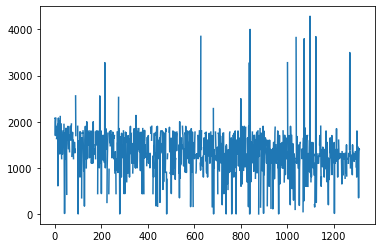

In [57]:
df['altitude_mean_meters'].plot()

In [58]:
df.head(1)

,Unnamed: 0,Species,Owner,Country.of.Origin,Farm.Name,Lot.Number,Mill,ICO.Number,Company,Altitude,Region,Producer,Number.of.Bags,Bag.Weight,In.Country.Partner,Harvest.Year,Grading.Date,Owner.1,Variety,Processing.Method,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Clean.Cup,Sweetness,Cupper.Points,Total.Cup.Points,Moisture,Category.One.Defects,Quakers,Color,Category.Two.Defects,Expiration,Certification.Body,Certification.Address,Certification.Contact,unit_of_measurement,altitude_low_meters,altitude_high_meters,altitude_mean_meters
0,1,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,guji-hambela,METAD PLC,300,60 kg,METAD Agricultural Development plc,2014,"April 4th, 2015",metad plc,NaN,Washed / Wet,8.67,8.83,8.67,8.75,8.5,8.42,10.0,10.0,10.0,8.75,90.58,0.12,0,0.0,Green,0,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0


In [59]:
df = acquire()
df = clean(df)
df.head(1)

,country,region,number_of_bags,harvest_year,grading_date,variety,processing_method,aroma,flavor,aftertaste,acidity,body,balance,uniformity,clean_cup,sweetness,cupper_points,total_cup_points,moisture,category_one_defects,quakers,color,category_two_defects,altitude_mean_meters,bag_weight,grading_month,grading_year,grading_day,excellent_rating
1,Ethiopia,guji-hambela,300,2014,2015-04-04,Other,Washed / Wet,8.75,8.67,8.5,8.58,8.42,8.42,10.0,10.0,10.0,8.58,89.92,0.12,0,0.0,Green,1,2075.0,60.0,4,2015,4,1


In [60]:
df['total_bag_weight'] = df['number_of_bags'] * df['bag_weight']

In [61]:
df[['total_bag_weight', 'number_of_bags', 'bag_weight']]

,total_bag_weight,number_of_bags,bag_weight
1,18000.0,300,60.0
4,18000.0,300,60.0
9,3000.0,50,60.0
11,10.0,10,1.0
12,10.0,10,1.0
...,...,...,...
1306,12.0,12,1.0
1307,2.0,1,2.0
1308,37950.0,550,69.0
1309,275.0,275,1.0


In [62]:
df.rename(columns={'Country.of.Origin':'country', 'Region':'region', 'Number.of.Bags':'number_of_bags', 'Harvest.Year':'harvest_year', 
                   'Grading.Date':'grading_date', 'Variety':'variety', 'Processing.Method':'processing_method', 'Aroma':'aroma',
                   'Flavor':'flavor', 'Aftertaste':'aftertaste', 'Acidity':'acidity', 'Body':'body', 'Balance':'balance',
                   'Uniformity':'uniformity', 'Clean.Cup':'clean_cup', 'Sweetness':'sweetness', 'Cupper.Points':'cupper_points',
                   'Total.Cup.Points':'total_cup_points', 'Moisture':'moisture', 'Category.One.Defects':'category_one_defects', 
                   'Quakers':'quakers', 'Color':'color', 'Category.Two.Defects': 'category_two_defects'})

,country,region,number_of_bags,harvest_year,grading_date,variety,processing_method,aroma,flavor,aftertaste,acidity,body,balance,uniformity,clean_cup,sweetness,cupper_points,total_cup_points,moisture,category_one_defects,quakers,color,category_two_defects,altitude_mean_meters,bag_weight,grading_month,grading_year,grading_day,excellent_rating,total_bag_weight
1,Ethiopia,guji-hambela,300,2014,2015-04-04,Other,Washed / Wet,8.75,8.67,8.50,8.58,8.42,8.42,10.00,10.00,10.00,8.58,89.92,0.12,0,0.0,Green,1,2075.00,60.0,4,2015,4,1,18000.0
4,Ethiopia,guji-hambela,300,2014,2015-04-04,Other,Washed / Wet,8.25,8.50,8.25,8.50,8.42,8.33,10.00,10.00,10.00,8.58,88.83,0.12,0,0.0,Green,2,2075.00,60.0,4,2015,4,1,18000.0
9,Ethiopia,"snnp/kaffa zone,gimbowereda",50,2014,2015-03-30,Other,Natural / Dry,8.08,8.58,8.50,8.50,7.67,8.42,10.00,10.00,10.00,8.50,88.25,0.10,0,0.0,Green,4,1822.50,60.0,3,2015,30,1,3000.0
11,United States,antioquia,10,2014,2015-03-13,Other,Washed / Wet,8.25,8.42,8.17,8.33,8.08,8.17,10.00,10.00,10.00,8.50,87.92,0.00,0,0.0,Green,0,1872.00,1.0,3,2015,13,1,10.0
12,United States,antioquia,10,2014,2015-03-13,Other,Washed / Wet,8.08,8.67,8.33,8.42,8.00,8.08,10.00,10.00,10.00,8.33,87.92,0.00,0,0.0,Green,0,1943.00,1.0,3,2015,13,1,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1306,Mexico,juchique de ferrer,12,2012,2012-09-17,Bourbon,Washed / Wet,7.08,6.83,6.25,7.42,7.25,6.75,10.00,0.00,10.00,6.75,68.33,0.11,0,0.0,Green,20,900.00,1.0,9,2012,17,0,12.0
1307,Haiti,"department d'artibonite , haiti",1,2012,2012-05-24,Typica,Natural / Dry,6.75,6.58,6.42,6.67,7.08,6.67,9.33,6.00,6.00,6.42,67.92,0.14,8,0.0,Blue-Green,16,350.00,2.0,5,2012,24,0,2.0
1308,Nicaragua,jalapa,550,2016,2017-06-06,Caturra,Other,7.25,6.58,6.33,6.25,6.42,6.08,6.00,6.00,6.00,6.17,63.08,0.13,1,0.0,Green,5,1100.00,69.0,6,2017,6,0,37950.0
1309,Guatemala,nuevo oriente,275,2012,2012-05-24,Catuai,Washed / Wet,7.50,6.67,6.67,7.67,7.33,6.67,8.00,1.33,1.33,6.67,59.83,0.10,0,0.0,Green,4,1417.32,1.0,5,2012,24,0,275.0


In [63]:
df.head()

,country,region,number_of_bags,harvest_year,grading_date,variety,processing_method,aroma,flavor,aftertaste,acidity,body,balance,uniformity,clean_cup,sweetness,cupper_points,total_cup_points,moisture,category_one_defects,quakers,color,category_two_defects,altitude_mean_meters,bag_weight,grading_month,grading_year,grading_day,excellent_rating,total_bag_weight
1,Ethiopia,guji-hambela,300,2014,2015-04-04,Other,Washed / Wet,8.75,8.67,8.50,8.58,8.42,8.42,10.0,10.0,10.0,8.58,89.92,0.12,0,0.0,Green,1,2075.0,60.0,4,2015,4,1,18000.0
4,Ethiopia,guji-hambela,300,2014,2015-04-04,Other,Washed / Wet,8.25,8.50,8.25,8.50,8.42,8.33,10.0,10.0,10.0,8.58,88.83,0.12,0,0.0,Green,2,2075.0,60.0,4,2015,4,1,18000.0
9,Ethiopia,"snnp/kaffa zone,gimbowereda",50,2014,2015-03-30,Other,Natural / Dry,8.08,8.58,8.50,8.50,7.67,8.42,10.0,10.0,10.0,8.50,88.25,0.10,0,0.0,Green,4,1822.5,60.0,3,2015,30,1,3000.0
11,United States,antioquia,10,2014,2015-03-13,Other,Washed / Wet,8.25,8.42,8.17,8.33,8.08,8.17,10.0,10.0,10.0,8.50,87.92,0.00,0,0.0,Green,0,1872.0,1.0,3,2015,13,1,10.0
12,United States,antioquia,10,2014,2015-03-13,Other,Washed / Wet,8.08,8.67,8.33,8.42,8.00,8.08,10.0,10.0,10.0,8.33,87.92,0.00,0,0.0,Green,0,1943.0,1.0,3,2015,13,1,10.0


In [64]:
df = acquire()

In [65]:
df = clean(df)

In [66]:
df.head()

,country,region,number_of_bags,harvest_year,grading_date,variety,processing_method,aroma,flavor,aftertaste,acidity,body,balance,uniformity,clean_cup,sweetness,cupper_points,total_cup_points,moisture,category_one_defects,quakers,color,category_two_defects,altitude_mean_meters,bag_weight,grading_month,grading_year,grading_day,excellent_rating
1,Ethiopia,guji-hambela,300,2014,2015-04-04,Other,Washed / Wet,8.75,8.67,8.50,8.58,8.42,8.42,10.0,10.0,10.0,8.58,89.92,0.12,0,0.0,Green,1,2075.0,60.0,4,2015,4,1
4,Ethiopia,guji-hambela,300,2014,2015-04-04,Other,Washed / Wet,8.25,8.50,8.25,8.50,8.42,8.33,10.0,10.0,10.0,8.58,88.83,0.12,0,0.0,Green,2,2075.0,60.0,4,2015,4,1
9,Ethiopia,"snnp/kaffa zone,gimbowereda",50,2014,2015-03-30,Other,Natural / Dry,8.08,8.58,8.50,8.50,7.67,8.42,10.0,10.0,10.0,8.50,88.25,0.10,0,0.0,Green,4,1822.5,60.0,3,2015,30,1
11,United States,antioquia,10,2014,2015-03-13,Other,Washed / Wet,8.25,8.42,8.17,8.33,8.08,8.17,10.0,10.0,10.0,8.50,87.92,0.00,0,0.0,Green,0,1872.0,1.0,3,2015,13,1
12,United States,antioquia,10,2014,2015-03-13,Other,Washed / Wet,8.08,8.67,8.33,8.42,8.00,8.08,10.0,10.0,10.0,8.33,87.92,0.00,0,0.0,Green,0,1943.0,1.0,3,2015,13,1


In [67]:
df['excellent_rating'] = np.where(df.total_cup_points > 85, 1, 0)

In [68]:
df.head()

,country,region,number_of_bags,harvest_year,grading_date,variety,processing_method,aroma,flavor,aftertaste,acidity,body,balance,uniformity,clean_cup,sweetness,cupper_points,total_cup_points,moisture,category_one_defects,quakers,color,category_two_defects,altitude_mean_meters,bag_weight,grading_month,grading_year,grading_day,excellent_rating
1,Ethiopia,guji-hambela,300,2014,2015-04-04,Other,Washed / Wet,8.75,8.67,8.50,8.58,8.42,8.42,10.0,10.0,10.0,8.58,89.92,0.12,0,0.0,Green,1,2075.0,60.0,4,2015,4,1
4,Ethiopia,guji-hambela,300,2014,2015-04-04,Other,Washed / Wet,8.25,8.50,8.25,8.50,8.42,8.33,10.0,10.0,10.0,8.58,88.83,0.12,0,0.0,Green,2,2075.0,60.0,4,2015,4,1
9,Ethiopia,"snnp/kaffa zone,gimbowereda",50,2014,2015-03-30,Other,Natural / Dry,8.08,8.58,8.50,8.50,7.67,8.42,10.0,10.0,10.0,8.50,88.25,0.10,0,0.0,Green,4,1822.5,60.0,3,2015,30,1
11,United States,antioquia,10,2014,2015-03-13,Other,Washed / Wet,8.25,8.42,8.17,8.33,8.08,8.17,10.0,10.0,10.0,8.50,87.92,0.00,0,0.0,Green,0,1872.0,1.0,3,2015,13,1
12,United States,antioquia,10,2014,2015-03-13,Other,Washed / Wet,8.08,8.67,8.33,8.42,8.00,8.08,10.0,10.0,10.0,8.33,87.92,0.00,0,0.0,Green,0,1943.0,1.0,3,2015,13,1


In [69]:
 df.total_cup_points.median(),  df.total_cup_points.max()

(82.42, 89.92)

In [70]:
len(df[df.total_cup_points < 80])

132

In [71]:
len(df)

982

In [72]:
df.at[41, 'altitude_mean_meters']=1150
df.at[42, 'altitude_mean_meters']=1150
df.head()

,country,region,number_of_bags,harvest_year,grading_date,variety,processing_method,aroma,flavor,aftertaste,acidity,body,balance,uniformity,clean_cup,sweetness,cupper_points,total_cup_points,moisture,category_one_defects,quakers,color,category_two_defects,altitude_mean_meters,bag_weight,grading_month,grading_year,grading_day,excellent_rating
1,Ethiopia,guji-hambela,300,2014,2015-04-04,Other,Washed / Wet,8.75,8.67,8.50,8.58,8.42,8.42,10.0,10.0,10.0,8.58,89.92,0.12,0,0.0,Green,1,2075.0,60.0,4,2015,4,1
4,Ethiopia,guji-hambela,300,2014,2015-04-04,Other,Washed / Wet,8.25,8.50,8.25,8.50,8.42,8.33,10.0,10.0,10.0,8.58,88.83,0.12,0,0.0,Green,2,2075.0,60.0,4,2015,4,1
9,Ethiopia,"snnp/kaffa zone,gimbowereda",50,2014,2015-03-30,Other,Natural / Dry,8.08,8.58,8.50,8.50,7.67,8.42,10.0,10.0,10.0,8.50,88.25,0.10,0,0.0,Green,4,1822.5,60.0,3,2015,30,1
11,United States,antioquia,10,2014,2015-03-13,Other,Washed / Wet,8.25,8.42,8.17,8.33,8.08,8.17,10.0,10.0,10.0,8.50,87.92,0.00,0,0.0,Green,0,1872.0,1.0,3,2015,13,1
12,United States,antioquia,10,2014,2015-03-13,Other,Washed / Wet,8.08,8.67,8.33,8.42,8.00,8.08,10.0,10.0,10.0,8.33,87.92,0.00,0,0.0,Green,0,1943.0,1.0,3,2015,13,1


# Notes

- Some bag weights are in kg others in lbs, Anything not labeled in lbs or kg must be dropped
- Some altitude low meters are in meters some in ft

# Encoded / Create Dummies

In [73]:
df = acquire()
df = clean(df)

In [74]:
df.head(1)
cols =  ['country', 'region', 'grading_date', 'variety', 'processing_method', 'color', 'grading_month', 'grading_year', 'grading_day']

In [75]:
dummy_columns = ['variety', 'processing_method', 'color']

In [76]:
df_dummy = pd.get_dummies(df[dummy_columns])

In [77]:
df_dummy = df_dummy.drop(columns=['color_Blue-Green'])

In [78]:
df = pd.concat([df, df_dummy], axis = 1)

In [79]:
df = acquire()
df = clean(df)
df = encode(df)

# If i had more time i would have created a continent column and created dummies for that too

In [80]:
# variety, and cleaning method, maybe elavation (bottom end)

In [81]:
def remove_outliers(df):
    df = df[(df.processing_method != 'Other') & (df.processing_method != 'Pulped natural / honey')]
    
    df = df[df.variety != 'Catimor']
    df = df[df.variety != 'SL14']
    df = df[df.variety != 'SL28']
    df = df[df.variety != 'Pacas']
    df = df[df.variety != 'Gesha']
    df = df[df.variety != 'Pacamara']
    df = df[df.variety != 'SL34']
    df = df[df.variety != 'Java']
    df = df[df.variety != 'Ethiopian Yirgacheffe']
    df = df[df.variety != 'Blue Mountain']
    df = df[df.variety != 'Ruiru 11']
    df = df[df.variety != 'Ethiopian Heirlooms']
    df = df[df.variety != 'Sumatra Lintong']
    df = df[df.variety != 'Sumatra']
    df = df[df.variety != 'Pache Comun']
    df = df[df.variety != 'Mandheling']
    df = df[df.variety != 'Marigojipe']
    df = df[df.variety != 'Arusha']
    df = df[df.variety != 'Moka Peaberry']
    df = df[df.variety != 'Peaberry']
    
    return df

In [82]:
df = acquire()
df = clean(df)

In [83]:
df.head(1)

,country,region,number_of_bags,harvest_year,grading_date,variety,processing_method,aroma,flavor,aftertaste,acidity,body,balance,uniformity,clean_cup,sweetness,cupper_points,total_cup_points,moisture,category_one_defects,quakers,color,category_two_defects,altitude_mean_meters,bag_weight,grading_month,grading_year,grading_day,excellent_rating
1,Ethiopia,guji-hambela,300,2014,2015-04-04,Other,Washed / Wet,8.75,8.67,8.5,8.58,8.42,8.42,10.0,10.0,10.0,8.58,89.92,0.12,0,0.0,Green,1,2075.0,60.0,4,2015,4,1


In [84]:
df.processing_method.value_counts()

Washed / Wet                 724
Natural / Dry                171
Semi-washed / Semi-pulped     53
Other                         25
Pulped natural / honey         9
Name: processing_method, dtype: int64

In [85]:
len(df)

982

In [86]:
df = df[(df.processing_method != 'Other') & (df.processing_method != 'Pulped natural / honey')]

In [87]:
len(df)

948

In [88]:
df.variety.value_counts()[df.variety.value_counts() < 25]

Catimor                  18
SL14                     16
SL28                     13
Pacas                    13
Gesha                    12
Pacamara                  8
SL34                      7
Ethiopian Yirgacheffe     2
Ruiru 11                  2
Java                      2
Blue Mountain             2
Arusha                    1
Moka Peaberry             1
Peaberry                  1
Marigojipe                1
Mandheling                1
Sumatra                   1
Sumatra Lintong           1
Pache Comun               1
Ethiopian Heirlooms       1
Name: variety, dtype: int64

In [89]:
# df = df[(df.variety != 'Catimor')
# df = df[(df.variety != 'SL14')
# df = df[(df.variety != 'SL28')
# df = df[(df.variety != 'Pacas')
# df = df[(df.variety != 'Gesha')
# df = df[(df.variety != 'Pacamara')
# df = df[(df.variety != 'SL34')
# df = df[(df.variety != 'Java')
# df = df[(df.variety != 'Ethiopian Yirgacheffe')
# df = df[(df.variety != 'Blue Mountain')
# df = df[(df.variety != 'Ruiru 11')
# df = df[(df.variety != 'Ethiopian Heirlooms')
# df = df[(df.variety != 'Sumatra Lintong')
# df = df[(df.variety != 'Sumatra')
# df = df[(df.variety != 'Pache Comun')
# df = df[(df.variety != 'Mandheling')
# df = df[(df.variety != 'Marigojipe')
# df = df[(df.variety != 'Arusha')
# df = df[(df.variety != 'Moka Peaberry')
# df = df[(df.variety != 'Peaberry')

In [90]:
df = acquire()
df = clean(df)
df = remove_outliers(df)

In [91]:
df.variety.value_counts()

Caturra           229
Bourbon           203
Typica            199
Other              93
Catuai             65
Yellow Bourbon     28
Mundo Novo         27
Name: variety, dtype: int64

In [92]:
df.processing_method.value_counts()

Washed / Wet                 645
Natural / Dry                150
Semi-washed / Semi-pulped     49
Name: processing_method, dtype: int64

In [93]:
df.loc[158]

country                          Costa Rica
region                        valle central
number_of_bags                          275
harvest_year                           2017
grading_date            2017-11-28 00:00:00
variety                             Caturra
processing_method              Washed / Wet
aroma                                  7.92
flavor                                 7.67
aftertaste                             7.92
acidity                                7.75
body                                   7.67
balance                                7.58
uniformity                             10.0
clean_cup                              10.0
sweetness                              10.0
cupper_points                           8.0
total_cup_points                       84.5
moisture                                0.1
category_one_defects                      0
quakers                                 0.0
color                            Blue-Green
category_two_defects            

<AxesSubplot:>

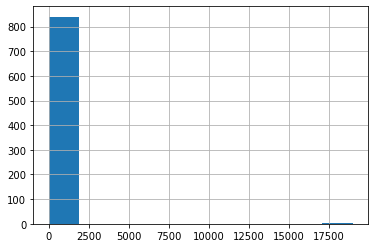

In [94]:
df.bag_weight.hist()

In [95]:
train, validate, test = wrangle()

In [96]:
list(train.columns)

['excellent_rating',
 'number_of_bags_scaled',
 'harvest_year_scaled',
 'aroma_scaled',
 'flavor_scaled',
 'aftertaste_scaled',
 'acidity_scaled',
 'body_scaled',
 'balance_scaled',
 'uniformity_scaled',
 'clean_cup_scaled',
 'sweetness_scaled',
 'cupper_points_scaled',
 'moisture_scaled',
 'category_one_defects_scaled',
 'quakers_scaled',
 'category_two_defects_scaled',
 'altitude_mean_meters_scaled',
 'bag_weight_scaled',
 'variety_Bourbon_scaled',
 'variety_Catuai_scaled',
 'variety_Caturra_scaled',
 'variety_Mundo Novo_scaled',
 'variety_Other_scaled',
 'variety_Typica_scaled',
 'variety_Yellow Bourbon_scaled',
 'processing_method_Natural / Dry_scaled',
 'processing_method_Semi-washed / Semi-pulped_scaled',
 'processing_method_Washed / Wet_scaled',
 'color_Green_scaled']

In [97]:
train.head()

,excellent_rating,number_of_bags_scaled,harvest_year_scaled,aroma_scaled,flavor_scaled,aftertaste_scaled,acidity_scaled,body_scaled,balance_scaled,uniformity_scaled,clean_cup_scaled,sweetness_scaled,cupper_points_scaled,moisture_scaled,category_one_defects_scaled,quakers_scaled,category_two_defects_scaled,altitude_mean_meters_scaled,bag_weight_scaled,variety_Bourbon_scaled,variety_Catuai_scaled,variety_Caturra_scaled,variety_Mundo Novo_scaled,variety_Other_scaled,variety_Typica_scaled,variety_Yellow Bourbon_scaled,processing_method_Natural / Dry_scaled,processing_method_Semi-washed / Semi-pulped_scaled,processing_method_Washed / Wet_scaled,color_Green_scaled
806,0,0.048414,0.285714,0.848000,0.874279,0.862353,0.864802,0.950119,0.874126,0.933,1.0,1.0,0.864802,0.705882,0.0,0.000,0.000000,0.151423,0.113924,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
835,0,0.332220,0.857143,0.848000,0.865052,0.872941,0.874126,0.881235,0.844988,1.000,1.0,1.0,0.854312,0.647059,0.0,0.125,0.066667,0.226785,0.734177,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
58,1,0.457429,0.285714,0.914286,0.922722,0.921176,0.970862,0.929929,0.912587,1.000,1.0,1.0,0.932401,0.588235,0.0,0.000,0.022222,0.330453,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
954,0,0.457429,0.714286,0.866286,0.855825,0.843529,0.864802,0.851544,0.835664,1.000,1.0,1.0,0.864802,0.529412,0.0,0.000,0.088889,0.314746,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
328,0,0.415693,0.285714,0.885714,0.893887,0.891765,0.912587,0.851544,0.903263,1.000,1.0,1.0,0.912587,0.647059,0.0,0.000,0.022222,0.408073,0.873418,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
